In [1]:
import os
import sys
sys.path.append('../mlai_research/')
import log
import utils
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import plotly.express as px
import plotly.graph_objects as go

In [2]:
logger = log.get_logger(__name__)
conf = utils.load_config("base")

06-Jan-24 22:06:20 - INFO - Starting 'load_config'.
06-Jan-24 22:06:20 - INFO - Finished 'load_config' in 0.0228 secs.


In [3]:
def encode_labels(df, column):
    """
    Encode labels in the specified column of the dataframe.

    Parameters:
    df (pandas.DataFrame): The dataframe containing the labels.
    column (str): The column name of the labels.

    Returns:
    df (pandas.DataFrame): The dataframe with encoded labels.
    """
    # label_encoder = preprocessing.LabelEncoder()
    # df[column] = label_encoder.fit_transform(df[column])

    label_map = {'xan': 1, 'dat': 2, 'other': 3, 'unk': 4}
    df[column] = df[column].map(label_map)
    return df


def split_data(df, test_size=0.1, val_size=0.1):
    """
    Split the dataframe into training, validation, and testing sets.

    Parameters:
    df (pandas.DataFrame): The dataframe to split.
    test_size (float): The proportion of the dataset to include in the test split.
    val_size (float): The proportion of the training set to include in the validation split.

    Returns:
    train_set (pandas.DataFrame): The training set.
    val_set (pandas.DataFrame): The validation set.
    test_set (pandas.DataFrame): The testing set.
    """
    train_set, test_set = train_test_split(df, test_size=test_size, random_state=42)
    train_set, val_set = train_test_split(train_set, test_size=val_size, random_state=42)
    return train_set, val_set, test_set


def upsample_minorities(df, label_column):
    """
    Upsample the minority classes in the dataframe to match the majority class count.

    Parameters:
    df (pandas.DataFrame): The dataframe to upsample.
    label_column (str): The column name of the labels.

    Returns:
    df_upsampled (pandas.DataFrame): The dataframe with the minority classes upsampled.
    """
    # Get the count of the most frequent class
    majority_class_count = df[label_column].value_counts().max()
    
    # Separate the majority and minority classes
    df_majority = df[df[label_column] == df[label_column].value_counts().idxmax()]
    df_minorities = df[df[label_column] != df[label_column].value_counts().idxmax()]
    
    # List to hold the upsampled dataframes
    upsampled_list = [df_majority]
    
    # Upsample each minority class and add to the list
    for class_index in df_minorities[label_column].unique():
        df_class_minority = df_minorities[df_minorities[label_column] == class_index]
        df_class_upsampled = resample(df_class_minority, 
                                      replace=True, 
                                      n_samples=majority_class_count, 
                                      random_state=42)
        upsampled_list.append(df_class_upsampled)
    
    # Concatenate all upsampled minority class DataFrames with the majority class DataFrame
    df_upsampled = pd.concat(upsampled_list)
    
    return df_upsampled


def calculate_metrics(y_true, y_pred):
    """
    Calculate accuracy, precision, recall, and F1 score.
    
    Parameters:
    y_true (list): List of true labels
    y_pred (list): List of predicted labels
    
    Returns:
    dict: A dictionary containing the calculated metrics
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}


def kappa_confidence_interval(y_true, y_pred, n_bootstrap=1000, alpha=0.05):
    """
    Calculate Cohen's Kappa score with confidence intervals using bootstrapping.
    
    Parameters:
    y_true: Ground truth (correct) target values.
    y_pred: Estimated targets as returned by a classifier.
    n_bootstrap: Number of bootstrap samples to create.
    alpha: Confidence interval, e.g., 0.05 for 95% confidence.
    
    Returns:
    kappa: Cohen's Kappa score
    lower: Lower bound of the confidence interval
    upper: Upper bound of the confidence interval
    """
    # Calculate Cohen's Kappa for the original data
    kappa = cohen_kappa_score(y_true, y_pred)
    
    # Generate bootstrap samples and calculate Cohen's Kappa for each sample
    bootstrap_kappas = []
    for _ in range(n_bootstrap):
        y_true_resampled, y_pred_resampled = resample(y_true, y_pred)
        kappa_resampled = cohen_kappa_score(y_true_resampled, y_pred_resampled)
        bootstrap_kappas.append(kappa_resampled)
    
    # Calculate lower and upper percentiles for the confidence interval
    lower = np.percentile(bootstrap_kappas, 100 * alpha / 2)
    upper = np.percentile(bootstrap_kappas, 100 * (1 - alpha / 2))
    
    return kappa, lower, upper



def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plot a confusion matrix.
    
    Parameters:
    y_true (list): List of true labels
    y_pred (list): List of predicted labels
    labels (list): List of unique labels
    
    Returns:
    None
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Plot the confusion matrix using plotly express:
    fig = px.imshow(cm, x=labels, y=labels, text_auto=True, color_continuous_scale=["white", "white"])
    # Add grid lines
    for i in range(len(labels)):
        fig.add_shape(
            go.layout.Shape(
                type="line",
                x0=-0.5,
                y0=i-0.5,
                x1=len(labels)-0.5,
                y1=i-0.5,
                line=dict(
                    color="black",
                    width=2,
                )
            )
        )
        fig.add_shape(
            go.layout.Shape(
                type="line",
                x0=i-0.5,
                y0=-0.5,
                x1=i-0.5,
                y1=len(labels)-0.5,
                line=dict(
                    color="black",
                    width=2,
                )
            )
        )

    fig.update_layout(title='Confusion Matrix', xaxis_title='Predicted', yaxis_title='True', coloraxis_showscale=False)
    fig.show()
    # fig.update_layout(title='Confusion Matrix', xaxis_title='Predicted', yaxis_title='True', coloraxis_showscale=False)
    # fig.show()

    # plt.figure(figsize=(10, 7))
    # sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.show()


def plot_roc_curve(y_true, y_score, labels):
    """
    Plot a ROC curve.
    
    Parameters:
    y_true (list): List of true labels
    y_score (list): List of predicted scores
    labels (list): List of unique labels
    
    Returns:
    None
    """
    y_true_bin = label_binarize(y_true, classes=labels)
    n_classes = y_true_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


def self_training(classifier, X_labeled, y_labeled, X_unlabeled, threshold=0.9, max_iter=10):
    """
    Perform self-training with the given classifier.

    Parameters:
    - classifier: a classifier that has fit and predict_proba methods.
    - X_labeled: features of the labeled data.
    - y_labeled: labels of the labeled data.
    - X_unlabeled: features of the unlabeled data.
    - threshold: confidence threshold for labeling unlabeled data.
    - max_iter: maximum number of iterations.

    Returns:
    - The trained classifier.
    """
    classifier = clone(classifier)  # create a new instance of the classifier
    for i in range(max_iter):
        classifier.fit(X_labeled, y_labeled)
        if X_unlabeled.shape[0] == 0:
            break  # no more unlabeled data
        probs = classifier.predict_proba(X_unlabeled)
        max_probs = probs.max(axis=1)
        confident = max_probs > threshold
        if not confident.any():
            break  # no confident predictions
        X_labeled = np.concatenate([X_labeled, X_unlabeled[confident]])
        y_labeled = np.concatenate([y_labeled, probs[confident].argmax(axis=1)])
        X_unlabeled = X_unlabeled[~confident]
    return classifier


def train_and_evaluate_model(X, y, model, n_splits=3):
    """
    Train a model using k-fold cross-validation and return the trained model and performance metrics.

    Parameters:
    X (numpy.ndarray): Feature matrix.
    y (numpy.ndarray): Labels array.
    model (sklearn.base.BaseEstimator): An instance of an sklearn classifier.
    n_splits (int): Number of folds for k-fold cross-validation.

    Returns:
    model (sklearn.base.BaseEstimator): Trained sklearn model.
    cv_results (dict): Dictionary with cross-validation results.
    """
    # Define k-fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_results = cross_validate(model, X, y, cv=kf, return_train_score=True, return_estimator=True)

    # Retrieve the model from the last fold
    trained_model = cv_results['estimator'][-1]

    # Print out the mean and standard deviation of the test score for each fold
    print(f"Mean test score: {np.mean(cv_results['test_score']):.4f}")
    print(f"Standard deviation of test score: {np.std(cv_results['test_score']):.4f}")

    return trained_model, cv_results

# Load Data

In [4]:
df = pd.read_csv(f"{conf.data.path_feat}{conf.data.fn_feat}")
df.shape, df['label'].value_counts()

((327, 1583),
 unk      299
 xan       15
 other     10
 dat        3
 Name: label, dtype: int64)

# Prepare Data 

- Split labelled, unlabelled
- Upsample lower class
- Drop true labels

In [5]:
# df = encode_labels(df, 'label')
df_unlabeled = df[df['label'] == 'unk']
df_labeled = df[df['label'] != 'unk']
dflup = upsample_minorities(df_labeled, 'label')
shuffled_df = dflup.sample(frac=1, random_state=13).reset_index(drop=True)
X_labeled = shuffled_df.drop('label', axis=1).values
y_labeled = shuffled_df['label'].values

X_labeled_train = X_labeled[:int(len(X_labeled) * 0.8)]
y_labeled_train = y_labeled[:int(len(y_labeled) * 0.8)]

X_labeled_val = X_labeled[int(len(X_labeled) * 0.8):]
y_labeled_val = y_labeled[int(len(y_labeled) * 0.8):]

X_unlabeled = df_unlabeled.drop('label', axis=1).values

In [6]:
y_labeled, y_labeled.shape

(array(['dat', 'dat', 'dat', 'other', 'xan', 'other', 'other', 'dat',
        'dat', 'other', 'dat', 'xan', 'xan', 'xan', 'xan', 'xan', 'dat',
        'xan', 'xan', 'other', 'dat', 'xan', 'dat', 'other', 'other',
        'dat', 'other', 'other', 'other', 'xan', 'dat', 'other', 'xan',
        'xan', 'dat', 'xan', 'xan', 'other', 'dat', 'other', 'dat', 'dat',
        'other', 'xan', 'other'], dtype=object),
 (45,))

# Create classifer

In [7]:
# Create a Random Forest classifier
model = RandomForestClassifier()

# Train Classifer

In [8]:
trained_model, cv_results = train_and_evaluate_model(X_labeled_train, y_labeled_train, model, n_splits=3)

Mean test score: 0.7500
Standard deviation of test score: 0.0000


In [9]:
cv_results

{'fit_time': array([0.05089307, 0.04814482, 0.05050802]),
 'score_time': array([0.0042491 , 0.00322723, 0.00333309]),
 'estimator': [RandomForestClassifier(),
  RandomForestClassifier(),
  RandomForestClassifier()],
 'test_score': array([0.75, 0.75, 0.75]),
 'train_score': array([1., 1., 1.])}

In [10]:
y_labeled_val_pred = trained_model.predict(X_labeled_val)

In [11]:
y_labeled_val

array(['xan', 'other', 'dat', 'other', 'dat', 'dat', 'other', 'xan',
       'other'], dtype=object)

In [115]:
metrics_val = calculate_metrics(y_labeled_val, y_labeled_val_pred)
print(f'Training data metrics: {metrics_val}')

Training data metrics: {'accuracy': 0.7777777777777778, 'precision': 0.8888888888888888, 'recall': 0.7777777777777778, 'f1': 0.7777777777777777}


In [116]:
kappa_val, lower_val, upper_val = kappa_confidence_interval(y_labeled_val, y_labeled_val_pred)
print(f"Cohen's Kappa: {kappa_val}, 95% CI: ({lower_val}, {upper_val})")

Cohen's Kappa: 0.6785714285714286, 95% CI: (0.2500000000000001, 1.0)


In [12]:
# cm = confusion_matrix(y_labeled_val, y_labeled_val_pred, labels=['xan', 'dat', 'other'])
# cm

In [13]:
plot_confusion_matrix(y_labeled_val, y_labeled_val_pred, trained_model.classes_)

In [14]:
classifier = self_training(model, X_labeled, y_labeled, X_unlabeled)

In [15]:
y_labeled_pred = classifier.predict(X_labeled)

In [16]:
y_labeled

array(['dat', 'dat', 'dat', 'other', 'xan', 'other', 'other', 'dat',
       'dat', 'other', 'dat', 'xan', 'xan', 'xan', 'xan', 'xan', 'dat',
       'xan', 'xan', 'other', 'dat', 'xan', 'dat', 'other', 'other',
       'dat', 'other', 'other', 'other', 'xan', 'dat', 'other', 'xan',
       'xan', 'dat', 'xan', 'xan', 'other', 'dat', 'other', 'dat', 'dat',
       'other', 'xan', 'other'], dtype=object)

In [17]:
y_labeled_pred

array(['dat', 'dat', 'dat', 'other', 'xan', 'other', 'other', 'dat',
       'dat', 'other', 'dat', 'xan', 'xan', 'xan', 'xan', 'xan', 'dat',
       'xan', 'xan', 'other', 'dat', 'xan', 'dat', 'other', 'other',
       'dat', 'other', 'other', 'other', 'xan', 'dat', 'other', 'xan',
       'xan', 'dat', 'xan', 'xan', 'other', 'dat', 'other', 'dat', 'dat',
       'other', 'xan', 'other'], dtype=object)

In [18]:
y_labeled.shape, y_labeled_pred.shape

((45,), (45,))

In [19]:
kappa, lower, upper = kappa_confidence_interval(y_labeled, y_labeled_pred)
print(f"Cohen's Kappa: {kappa}, 95% CI: ({lower}, {upper})")

Cohen's Kappa: 1.0, 95% CI: (1.0, 1.0)


Training data metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


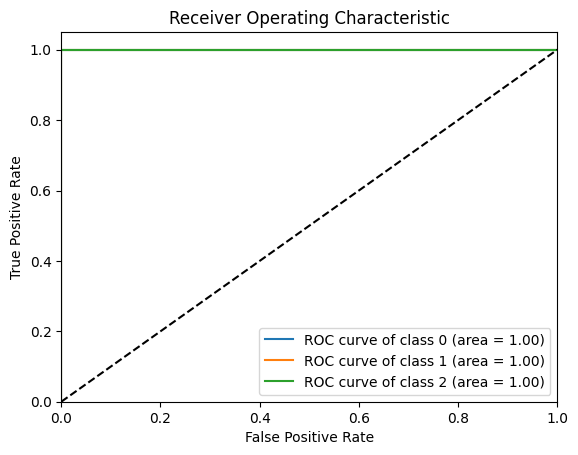

In [20]:
# Plot the confusion matrix and ROC curve of training data
metrics = calculate_metrics(y_labeled, y_labeled_pred)
print(f'Training data metrics: {metrics}')
plot_confusion_matrix(y_labeled, y_labeled_pred, classifier.classes_)
plot_roc_curve(y_labeled, classifier.predict_proba(X_labeled), classifier.classes_)

# Predict on Unlabeled Data

In [21]:
def proba_confidence_interval(X_unlabeled, classifier, n_bootstrap=1000, alpha=0.05):
    """
    Calculate confidence intervals for predicted probabilities using bootstrapping.
    
    Parameters:
    X_unlabeled: Unlabeled data.
    classifier: Trained classifier.
    n_bootstrap: Number of bootstrap samples to create.
    alpha: Confidence interval, e.g., 0.05 for 95% confidence.
    
    Returns:
    lower: Lower bound of the confidence interval for each sample.
    upper: Upper bound of the confidence interval for each sample.
    """
    # Generate bootstrap samples and calculate predicted probabilities for each sample
    bootstrap_probas = []
    for _ in range(n_bootstrap):
        X_resampled = resample(X_unlabeled)
        proba_resampled = classifier.predict_proba(X_resampled)
        bootstrap_probas.append(proba_resampled)
    
    # Calculate lower and upper percentiles for the confidence interval
    lower = np.percentile(bootstrap_probas, 100 * alpha / 2, axis=0)
    upper = np.percentile(bootstrap_probas, 100 * (1 - alpha / 2), axis=0)
    
    return lower, upper

In [22]:
lower, upper = proba_confidence_interval(X_unlabeled, classifier)

In [23]:
lower.shape, upper.shape

((299, 3), (299, 3))

In [103]:
def plot_confidence_intervals(X_unlabeled, classifier, n_bins=10, n_bootstrap=1000, alpha=0.05):
    """
    Calculate confidence intervals for predicted probabilities and plot a histogram of their widths.

    Parameters:
    X_unlabeled: Unlabeled data.
    classifier: Trained classifier.
    n_bins: Number of bins for the histogram.
    n_bootstrap: Number of bootstrap samples to create.
    alpha: Confidence interval, e.g., 0.05 for 95% confidence.
    """
    # Calculate confidence intervals
    lower, upper = proba_confidence_interval(X_unlabeled, classifier, n_bootstrap, alpha)

    # Calculate the widths of the confidence intervals
    widths = upper - lower

    # Create a histogram of the widths
    fig = px.histogram(widths, nbins=n_bins)

    # Show the plot
    fig.show()


def plot_predicted_probabilities(probabilities, class_labels):
    # Convert the probabilities and class labels to a DataFrame
    df = pd.DataFrame(probabilities, columns=class_labels)
    
    # Melt the DataFrame to a long format for easier plotting
    df_melt = df.melt(var_name='Class', value_name='Predicted Probability')
    
    # Create a histogram for each class
    fig = px.histogram(df_melt, x='Predicted Probability', color='Class', nbins=50,
                       title='Predicted Probabilities for Each Class',
                       labels={'Predicted Probability': 'Predicted Probability', 'Class': 'Class'},
                       marginal='box', # display box plot on top margin
                       opacity=0.7,
                       barmode='overlay') # overlay histograms on top of one another
    
    fig.update_layout(width=600, height=600)

    fig.show()

In [99]:
y_pred = classifier.predict(X_unlabeled)
y_pred_proba = classifier.predict_proba(X_unlabeled)

In [104]:
plot_predicted_probabilities(y_pred_proba, classifier.classes_)

In [27]:
# plot_confidence_intervals(X_unlabeled, classifier, n_bins=20)

In [28]:
# Predict the labels of the unlabeled data
# y_pred = classifier.predict(X_unlabeled)
# y_pred_proba = classifier.predict_proba(X_unlabeled)

# Plot the confusion matrix and ROC curve of the unlabeled data
# calculate_metrics(df_unlabeled['label'], y_pred)
# plot_confusion_matrix(df_unlabeled['label'], y_pred, classifier.classes_)
# plot_roc_curve(df_unlabeled['label'], classifier.predict_proba(X_unlabeled), classifier.classes_)

# Add the predicted labels to the unlabeled data
# df_unlabeled['label'] = y_pred

# # Concatenate the labeled and unlabeled data
# df_concat = pd.concat([dflup, df_unlabeled])

In [29]:
# drop the label column from columns list:
cols = list(df.columns)
cols.remove('label')
cols.extend(['label_pred_proba', 'label_pred'])

In [30]:
# combine y_pred and y_pred_proba
y_pred_proba = y_pred_proba.max(axis=1)
y_pred_proba = y_pred_proba.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)
arr_unlabeled = np.concatenate([X_unlabeled, y_pred_proba, y_pred], axis=1)
df_unlabeled = pd.DataFrame(arr_unlabeled, columns=cols)

In [31]:
df_results = df_unlabeled[['pid', 'label_pred_proba', 'label_pred']]
df_results['label_pred_proba'] = df_results['label_pred_proba'].astype(float)
df_results['pid'] = df_results['pid'].astype(int)

/var/folders/0g/blggksdj42z52nv3fy0h5b880000gn/T/ipykernel_77161/3462471382.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/0g/blggksdj42z52nv3fy0h5b880000gn/T/ipykernel_77161/3462471382.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
df_results

,pid,label_pred_proba,label_pred
0,1000,0.40,xan
1,1001,0.57,xan
2,1002,0.52,other
3,1005,0.45,other
4,1006,0.63,xan
...,...,...,...
294,1467,0.38,other
295,1468,0.44,xan
296,1469,0.57,xan
297,1473,0.47,xan


In [90]:
def get_examples(df_results):

    df = df_results[~(df_results['label_pred'] == 'other')]

    # Group by 'label_pred' and get the max, min, and mean of 'label_pred_proba'
    result = df.groupby('label_pred')['label_pred_proba'].agg(['idxmax', 'idxmin', 'mean']).reset_index()

    # Get the rows with the max and min probabilities
    max_rows = df.loc[result['idxmax']].copy()
    min_rows = df.loc[result['idxmin']].copy()

    # Get the row in each class where 'label_pred_proba' is closest to the mean
    mean_rows = df.loc[df.groupby('label_pred')['label_pred_proba'].apply(lambda x: (x - x.mean()).abs().idxmin())]

    # Concatenate the max, min, and mean rows
    examples = pd.concat([max_rows, min_rows, mean_rows], ignore_index=True).sort_values(by='label_pred', ascending=False).reset_index(drop=True)
    examples['label_pred'] = examples['label_pred'].map({'xan': "Xanthium s.", 'dat': "Datura s.", 'unk': "Unknown"})
    return examples


def get_examples_fns(examples):
    ex_pids = list(f"{str(pid)}_rgb" for pid in examples['pid'])
    ex_fns = []
    ex_fns = utils.get_filenames(conf.data.path_int_cr_tif, "tif", ex_pids)
    return ex_fns

In [91]:
examples = get_examples(df_results)
examples

,pid,label_pred_proba,label_pred
0,1227,0.70,Xanthium s.
1,1168,0.38,Xanthium s.
2,1044,0.52,Xanthium s.
3,1277,0.47,Datura s.
4,1169,0.35,Datura s.
5,1171,0.38,Datura s.


In [92]:
# ex_fns = get_examples_fns(examples)
ex_fns = ['../data/02_intermediate/03_cropped_tifs/1227_rgb_unk.tif',
'../data/02_intermediate/03_cropped_tifs/1168_rgb_unk.tif',
'../data/02_intermediate/03_cropped_tifs/1044_rgb_unk.tif',
'../data/02_intermediate/03_cropped_tifs/1277_rgb_unk.tif',
'../data/02_intermediate/03_cropped_tifs/1169_rgb_unk.tif',
'../data/02_intermediate/03_cropped_tifs/1171_rgb_unk.tif']

In [93]:
rgb_imgs = utils.load_rgb_rasters(ex_fns)

06-Jan-24 22:34:45 - INFO - Loaded RGB img shape: (87, 87, 3)


In [94]:
len(rgb_imgs)

6

In [112]:
def plot_images(images, probabilities, row_labels, col_labels, title):
    """
    Plots a grid of images with custom row and column labels.

    Parameters:
    - images (list of numpy.ndarray): The images to plot.
    - probabilities (list of float): The probabilities to overlay on the images.
    - row_labels (list of str): The row labels.
    - col_labels (list of str): The column labels.
    - title (str): The title of the figure.
    """
    num_rows = len(row_labels)
    num_cols = len(col_labels)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4*num_cols, 4*num_rows))

    for i, row_label in enumerate(row_labels):
        for j, col_label in enumerate(col_labels):
            # Calculate the index of the image in the flat list
            index = i * num_cols + j

            # Plot the image
            axes[i, j].imshow(images[index])

            # Overlay the probability
            axes[i, j].text(0.9, 2, f"p={probabilities[index]}", color='white', 
                            bbox=dict(facecolor='black', alpha=0.9), fontsize=18,)

            # Set the title of the subplot
            if i == 0:
                axes[i, j].set_title(col_label, fontsize=20)

        # Set the label of the row
        axes[i, 0].set_ylabel(row_label, fontsize=20)

    # Set the title of the figure
    fig.suptitle(title, fontsize=26)

    plt.tight_layout()
    plt.show()

In [113]:
examples['label_pred_proba']

0    0.70
1    0.38
2    0.52
3    0.47
4    0.35
5    0.38
Name: label_pred_proba, dtype: float64

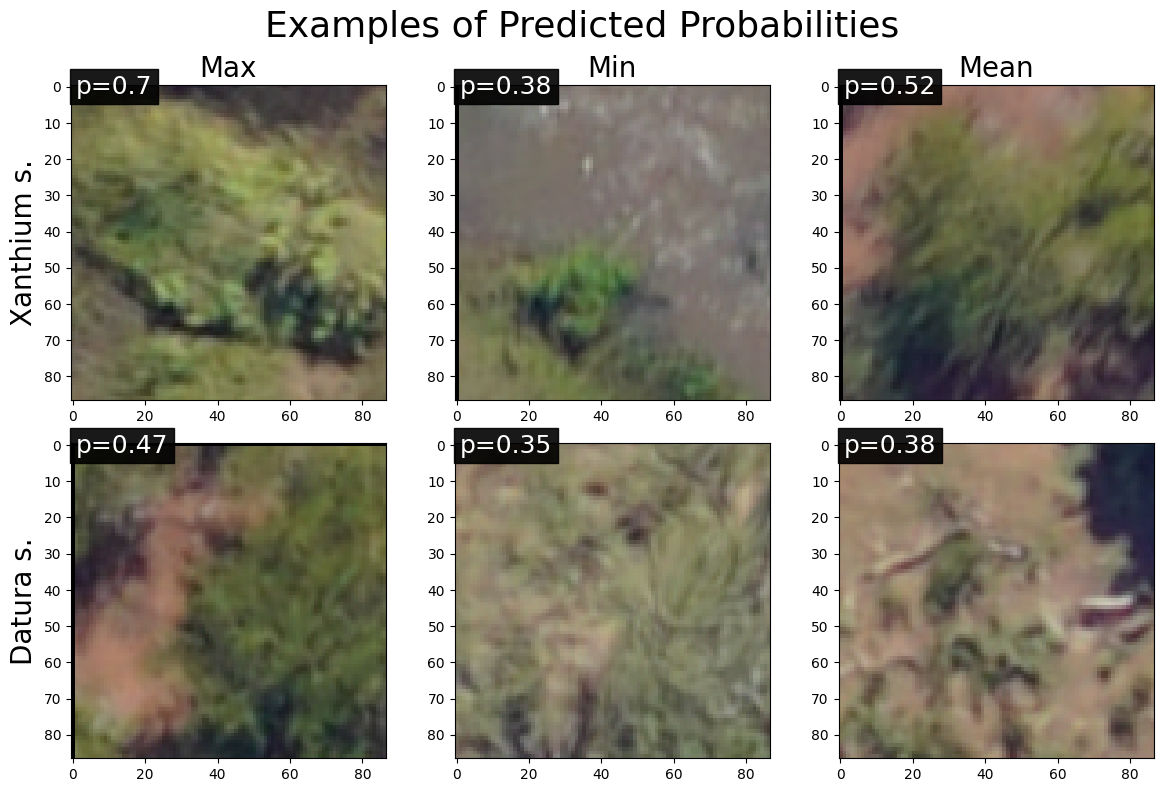

In [114]:
plot_images(rgb_imgs, examples['label_pred_proba'], examples['label_pred'].unique(), ['Max', 'Min', 'Mean'], 'Examples of Predicted Probabilities')

In [ ]:
# plot_images(images, probabilities, row_labels, col_labels, title)